In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from functools import partial
from typing import Optional
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [4]:
from IPython.display import clear_output
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [5]:
USE_CUDA = torch.cuda.is_available()

print("cuda is available:", USE_CUDA)

cuda is available: True


#Score-matching: RefineNet

## Data

In [6]:
import numpy as np
from typing import Tuple

import torchvision


def load_MNIST() -> Tuple[np.ndarray, np.ndarray]:
    train_data = torchvision.datasets.MNIST(root="./", train=True, download=True)
    test_data = torchvision.datasets.MNIST(root="./", train=False, download=True)
    train_data, test_data = train_data.data.numpy(), test_data.data.numpy()
    axis_index = len(train_data.shape)
    train_data = np.expand_dims(train_data, axis=axis_index)
    test_data = np.expand_dims(test_data, axis=axis_index)

    return train_data, test_data


def load_CIFAR10() -> Tuple[np.ndarray, np.ndarray]:
    train_data = torchvision.datasets.CIFAR10(root="./", train=True, download=True)
    test_data = torchvision.datasets.CIFAR10(root="./", train=False, download=True)
    train_data, test_data = train_data.data, test_data.data

    return train_data, test_data


def _load_dataset(name: str) -> Tuple[np.ndarray, np.ndarray]:
    if name == "mnist":
        return load_MNIST()
    elif name == "cifar10":
        return load_CIFAR10()
    else:
        raise ValueError("The argument name must have the values 'mnist' or 'cifar10'")


def load_dataset(
    name: str, flatten: bool = False, binarize: bool = False
) -> Tuple[np.ndarray, np.ndarray]:

    train_data, test_data = _load_dataset(name)

    train_data = train_data.astype("float32")
    test_data = test_data.astype("float32")

    if binarize:
        train_data = (train_data > 128).astype("float32")
        test_data = (test_data > 128).astype("float32")
    else:
        train_data = train_data / 255.0
        test_data = test_data / 255.0

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    if flatten:
        train_data = train_data.reshape(len(train_data.shape[0]), -1)
        test_data = test_data.reshape(len(train_data.shape[0]), -1)

    return train_data, test_data

In [7]:
train_data, test_data = load_dataset('mnist')

100%|██████████| 9912422/9912422 [00:00<00:00, 122643301.40it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 16467603.84it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 118188040.82it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22438785.36it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
train_data.shape

In [7]:
BATCH_SIZE = 64
mnist_dataset = TensorDataset(torch.from_numpy(train_data)) # create your datset
mnist_dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE)

## Model

In [8]:
from models import CondRefineNetDilated

In [9]:
class NoiseConditionalScoreNetwork(nn.Module):
  def __init__(self, n_channels: int = 1, num_classes: int = 10, ngf: int = 64, image_size: int = 28) -> None:
    super().__init__()

    self.image_size = image_size
    self.n_channels = n_channels
    self.net = CondRefineNetDilated(image_size, num_classes, n_channels, ngf)


  def forward(self, input: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
    return self.net(input, sigma)

  def prior(self, n_samples):
    # sample from prior distribution
    noise = torch.randn(n_samples, self.n_channels, self.image_size, self.image_size)
    if USE_CUDA:
      return noise.cuda()
    return noise


  def sample(self, n_samples: int,
             n_steps: int,
             sigmas: torch.Tensor,
             eps: float = 0.00005,
             save_history: bool = False,
             save_freq: int = 100) -> torch.Tensor:
    # annealed Langevin dynamics
    x_k = self.prior(n_samples)
    history = []
    with torch.no_grad():
      for i, sigma in enumerate(sigmas):
        alpha = eps * sigma**2 / sigmas[-1]**2
        for k in range(n_steps):
          sigma_batch = torch.ones(n_samples, device=x_k.device, dtype=torch.int) * i
          score = self(x_k, sigma_batch)
          x_k += alpha * score.detach() / 2 + np.sqrt(alpha) * torch.randn_like(x_k)
          if save_history and k % save_freq == 0:
            history.append(x_k.cpu())

    if save_history:
      return x_k.cpu(), history

    return x_k.cpu()

## Train

In [10]:
def train_ncsn(
    model: object,
    train_loader: object,
    n_epochs: int,
    lr: float,
    sigmas: torch.Tensor,
    use_cuda: bool = False,
    weights_path: str = '',
    save_freq: int = 10
) -> dict:

  if use_cuda:
      model.cuda()
  model.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0, 0.9))

  batch_loss_history = {"loss": []}
  for epoch_i in range(n_epochs):
    for batch_i, x in tqdm(enumerate(train_loader)):
      x = x[0]
      batch_size = x.shape[0]
      if use_cuda:
        x = x.cuda()


      labels = torch.randint(len(sigmas), (batch_size,))
      sigma_batch = sigmas[labels].to(x.device)
      sigma_batch = sigma_batch.reshape(-1, *([1]*(len(x.shape) - 1)))

      standart_noise = torch.randn_like(x)
      x_noisy = x + standart_noise * sigma_batch


      optimizer.zero_grad()
      pred_scores = model(x_noisy, labels.to(x.device))

      noisy_scores = (-standart_noise / sigma_batch).reshape(batch_size, -1)
      pred_scores = pred_scores.reshape(batch_size, -1)

      losses = torch.sum((pred_scores - noisy_scores)**2, axis=-1) / 2
      loss = torch.mean(losses * sigma_batch.flatten()**2)

      loss.backward()
      optimizer.step()

      batch_loss_history["loss"].append(loss.data.cpu().numpy())


    clear_output()
    plt.plot(batch_loss_history["loss"])
    plt.title('Train loss')
    plt.show()

    if (epoch_i + 1) % save_freq == 0:
      torch.save(model.state_dict(), weights_path+'_{}.pth'.format(epoch_i + 1))


  return batch_loss_history

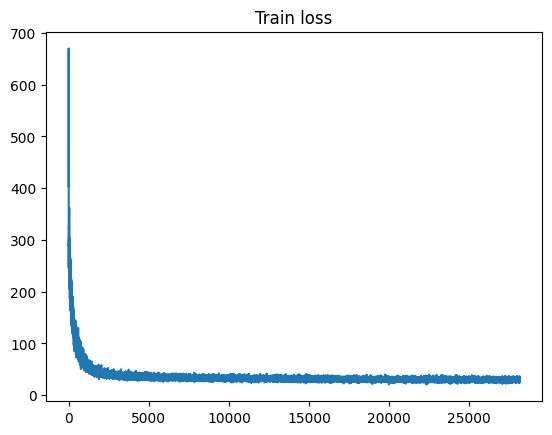

In [11]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(1), np.log(0.01), 10))).float()

refine_net = NoiseConditionalScoreNetwork()

loss_history = train_ncsn(model=refine_net,
                          train_loader=mnist_dataloader,
                          n_epochs=30,
                          lr=1e-3,
                          sigmas=sigmas,
                          use_cuda=USE_CUDA)

## Sampling

In [ ]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(1), np.log(0.01), 10))).float()

refine_net = NoiseConditionalScoreNetwork()
refine_net.load_state_dict(torch.load('/content/drive/MyDrive/NCSN/mnist_refine_net_20.pth'))
refine_net.cuda()

In [25]:
refine_net.eval()
samples, history = refine_net.sample(n_samples=10, n_steps=100, sigmas=sigmas, save_history=True)

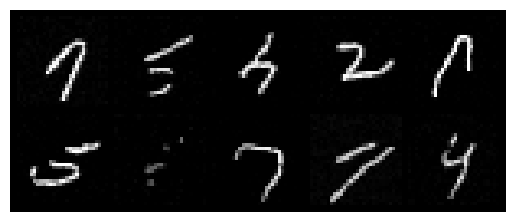

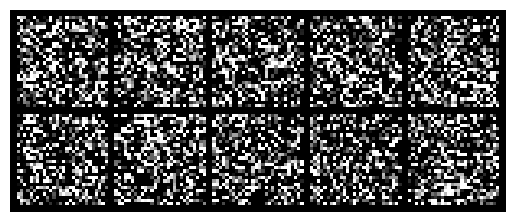

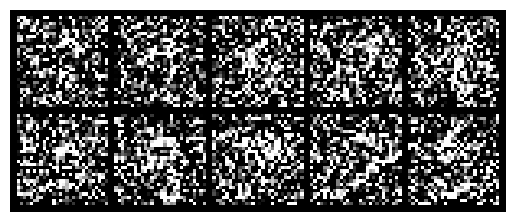

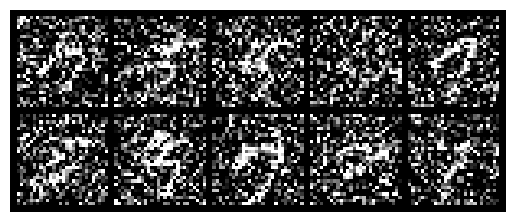

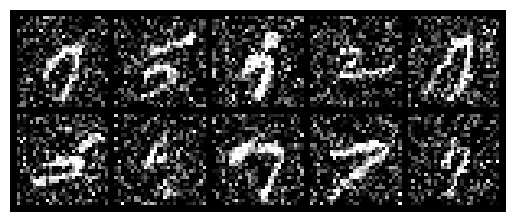

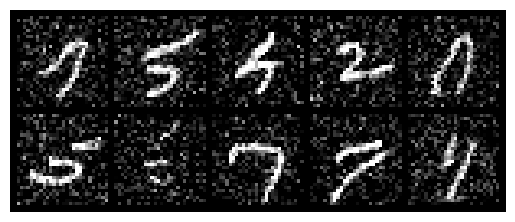

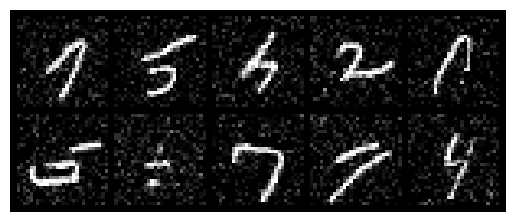

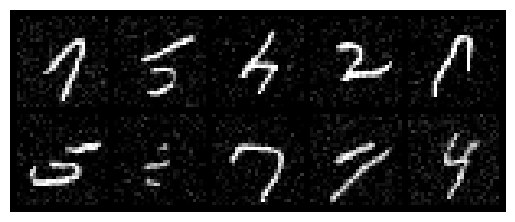

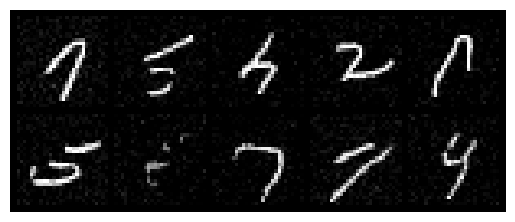

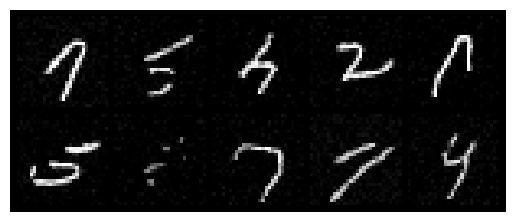

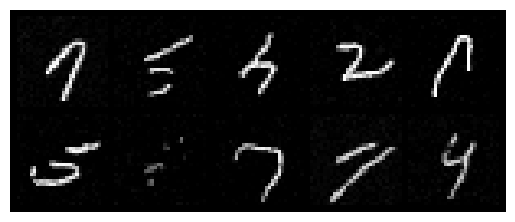

In [ ]:
from torchvision.utils import make_grid

grid_samples = make_grid(samples, nrow=5)

grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
#plt.figure(figsize=(6, 6))
plt.imshow(grid_img, cmap='Greys')
plt.axis("off")
plt.show()

for step in range(len(history)):
  grid_samples = make_grid(history[step], nrow=5)

  grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
  #plt.figure(figsize=(6, 6))
  plt.imshow(grid_img, cmap='Greys')
  plt.axis("off")
  plt.show()

# Score-matching: UNet

## Data

In [ ]:
resize_transform = torchvision.transforms.Compose([torchvision.transforms.Resize(32),
                                                  torchvision.transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST('MNIST', download=True, transform=resize_transform)

In [10]:
BATCH_SIZE = 64
mnist_dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE)

In [60]:
distances = []
for batch in mnist_dataloader:
  batch = batch[0].reshape(1, BATCH_SIZE, -1)
  distances.append(torch.mean(torch.cdist(batch, batch)))


(array([  1.,   0.,   1.,   6.,  29., 157., 359., 288.,  90.,   7.]),
 array([ 7.60168743,  8.00864697,  8.41560555,  8.82256508,  9.22952366,
         9.63648319, 10.04344273, 10.45040131, 10.85736084, 11.26431942,
        11.67127895]),
 <BarContainer object of 10 artists>)

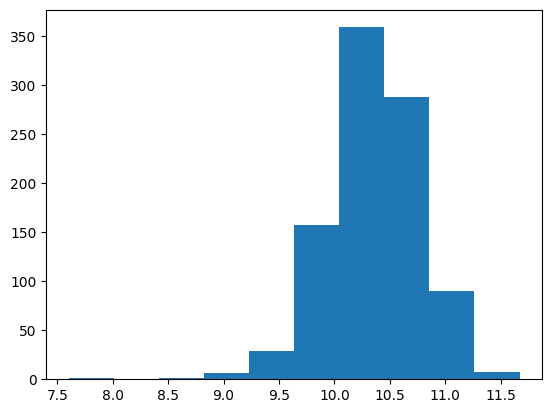

In [62]:
plt.hist(distances)

## Train

In [8]:
from models import UNet

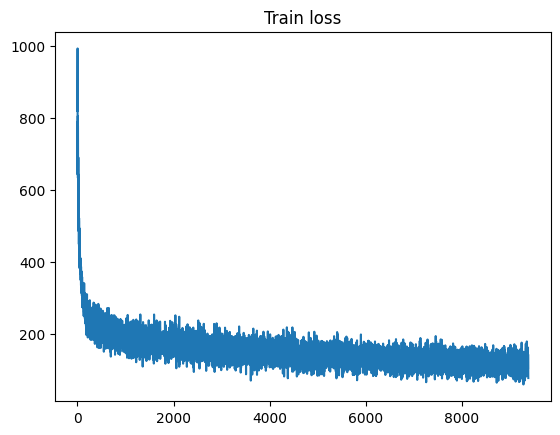

In [65]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(10), np.log(0.01), 10))).float() #1

unet_model = UNet(image_channels=1)

loss_history = train_ncsn(model=unet_model,
                          train_loader=mnist_dataloader,
                          n_epochs=10,
                          lr=2e-5,
                          sigmas=sigmas,
                          use_cuda=USE_CUDA,
                          weights_path='/content/drive/MyDrive/NCSN/mnist_unet_2')

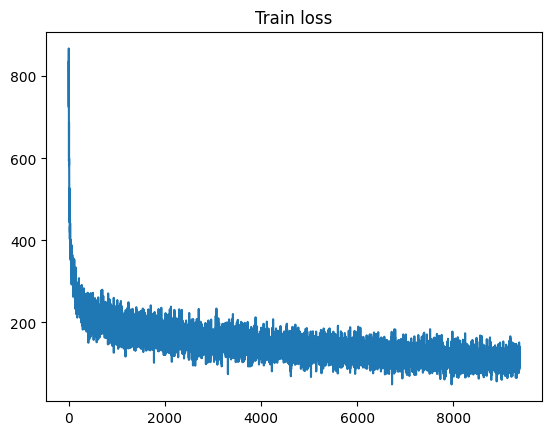

In [11]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(5), np.log(0.01), 10))).float()

unet_model = UNet(image_channels=1)

loss_history = train_ncsn(model=unet_model,
                          train_loader=mnist_dataloader,
                          n_epochs=10,
                          lr=2e-5,
                          sigmas=sigmas,
                          use_cuda=USE_CUDA,
                          weights_path='/content/drive/MyDrive/NCSN/mnist_unet_3')

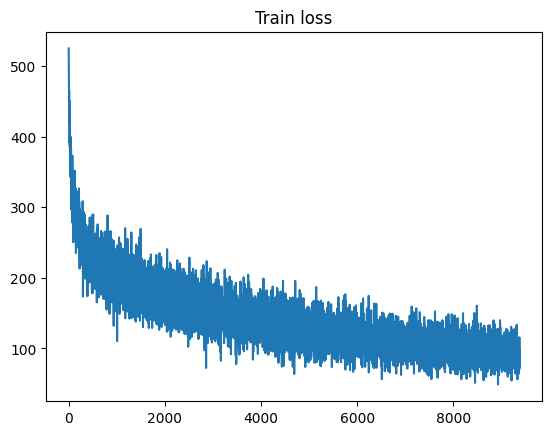

In [29]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(2), np.log(0.01), 10))).float()

unet_model = UNet(image_channels=1)

loss_history = train_ncsn(model=unet_model,
                          train_loader=mnist_dataloader,
                          n_epochs=10,
                          lr=2e-5,
                          sigmas=sigmas,
                          use_cuda=USE_CUDA,
                          weights_path='/content/drive/MyDrive/NCSN/2_mnist_unet')

## Sampling

In [15]:
def Lsample(model, n_samples: int,
             n_steps: int,
             sigmas: torch.Tensor,
             eps: float = 0.00005,
             save_history: bool = False,
             save_freq: int = 100) -> torch.Tensor:
    # annealed Langevin dynamics
    x_k = torch.randn(n_samples, 1, 32, 32).cuda()
    history = []
    if isinstance(n_steps, int):
      n_steps = [n_steps]*len(sigmas)

    with torch.no_grad():
      for i, sigma in enumerate(sigmas):
        alpha = eps * sigma**2 / sigmas[-1]**2
        for k in range(n_steps[i]):
          sigma_batch = torch.ones(n_samples, device=x_k.device, dtype=torch.int) * i
          score = model(x_k, sigma_batch)
          x_k += alpha * score.detach() / 2 + np.sqrt(alpha) * torch.randn_like(x_k)
          if save_history and k % save_freq == 0:
            history.append(x_k.cpu())

    if save_history:
      return x_k.cpu(), history

    return x_k.cpu()

In [30]:
unet_model.eval()
#n_steps = [100, 100, 100, 100, 50, 50, 50, 100, 150, 200]
n_steps = 100
samples, history = Lsample(unet_model, n_samples=10, n_steps=n_steps, sigmas=sigmas, save_history=True)

$\sigma_1 = 5$

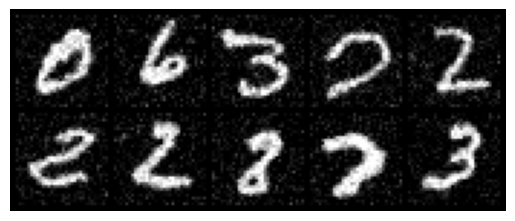

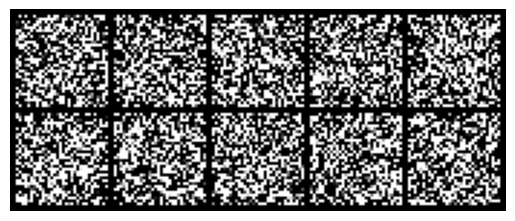

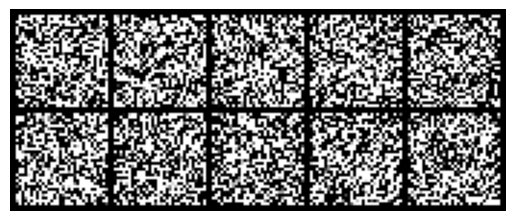

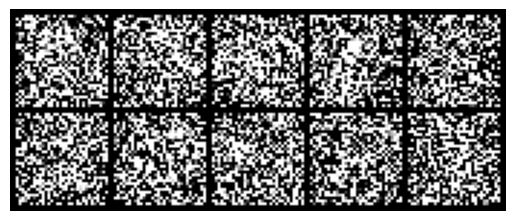

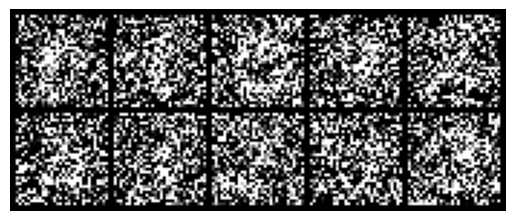

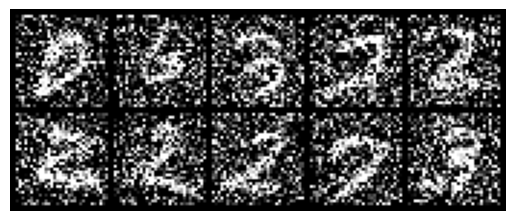

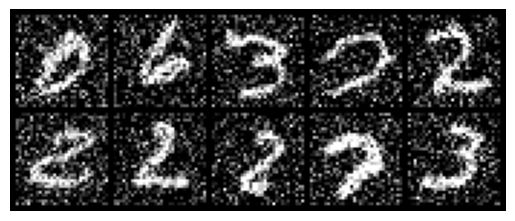

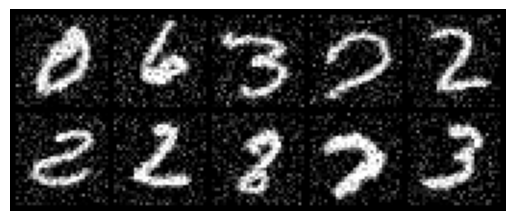

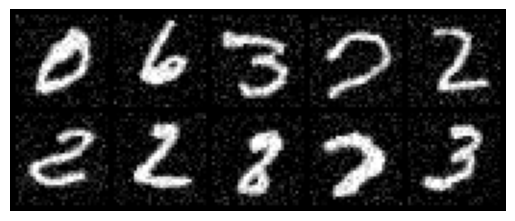

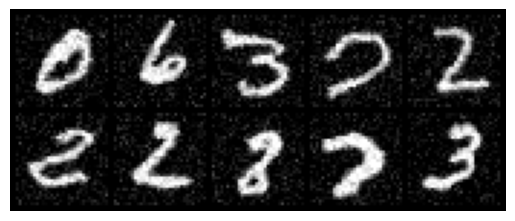

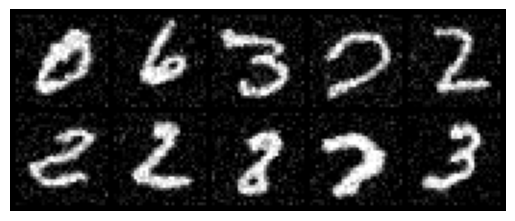

In [19]:
from torchvision.utils import make_grid

grid_samples = make_grid(samples, nrow=5)

grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
#plt.figure(figsize=(6, 6))
plt.imshow(grid_img, cmap='Greys')
plt.axis("off")
plt.show()

for step in range(len(history)):
  grid_samples = make_grid(history[step], nrow=5)

  grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
  #plt.figure(figsize=(6, 6))
  plt.imshow(grid_img, cmap='Greys')
  plt.axis("off")
  plt.show()

$\sigma_1 = 10$

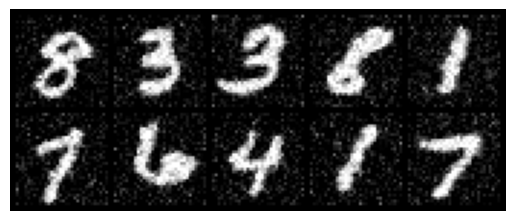

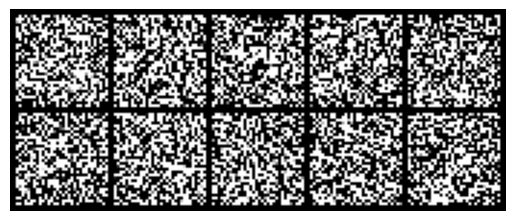

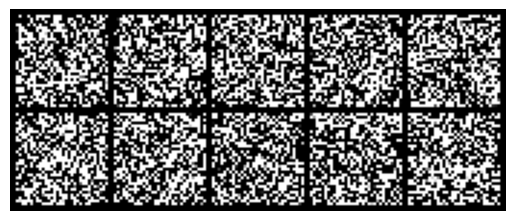

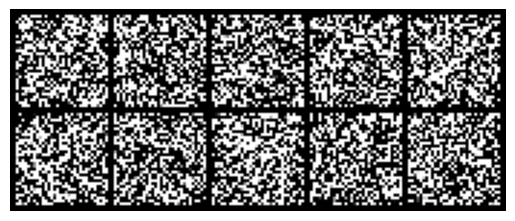

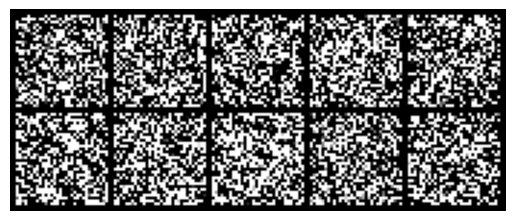

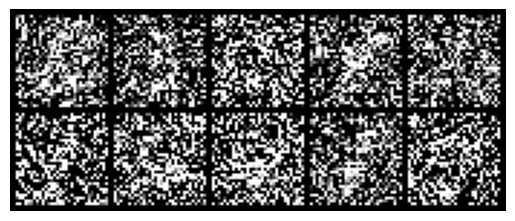

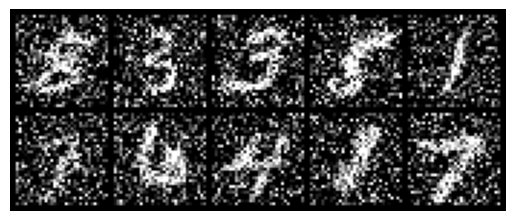

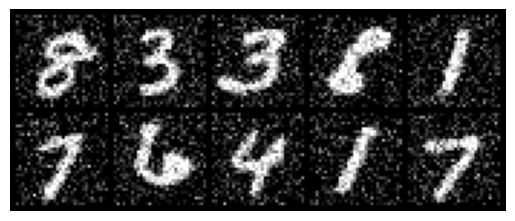

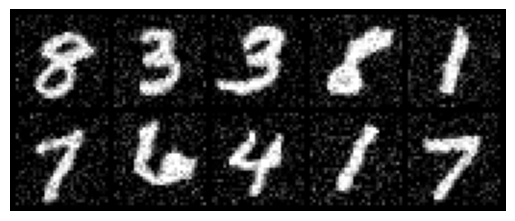

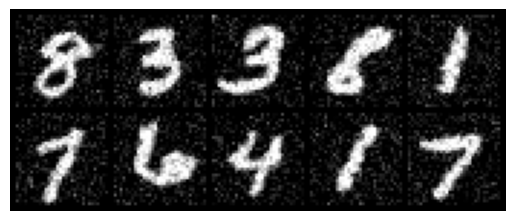

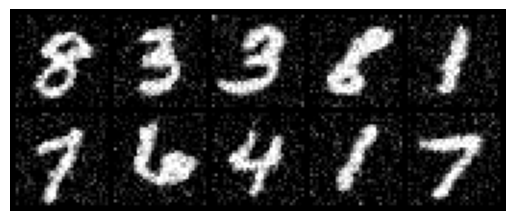

In [67]:
from torchvision.utils import make_grid

grid_samples = make_grid(samples, nrow=5)

grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
plt.imshow(grid_img, cmap='Greys')
plt.axis("off")
plt.show()

for step in range(len(history)):
  grid_samples = make_grid(history[step], nrow=5)

  grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
  #plt.figure(figsize=(6, 6))
  plt.imshow(grid_img, cmap='Greys')
  plt.axis("off")
  plt.show()

$\sigma_1 = 1$

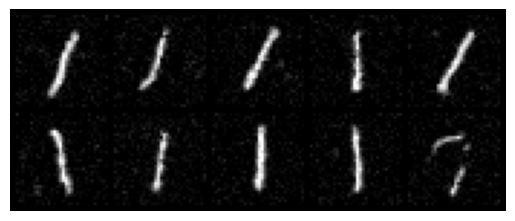

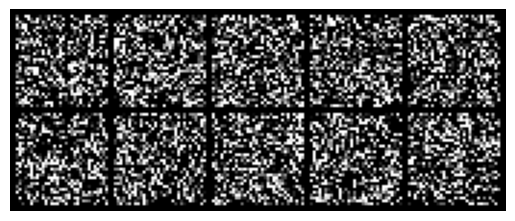

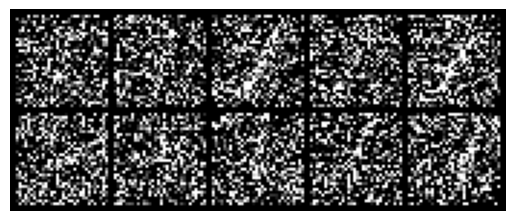

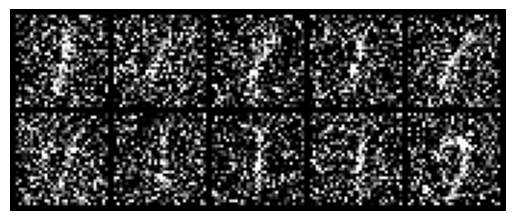

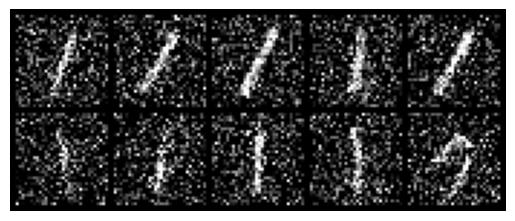

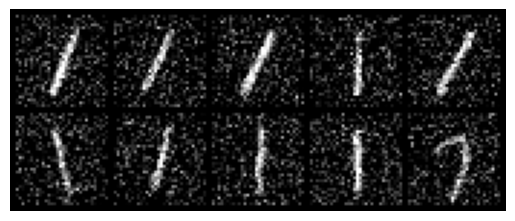

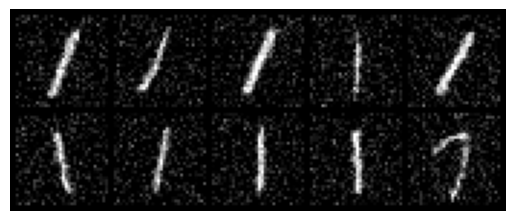

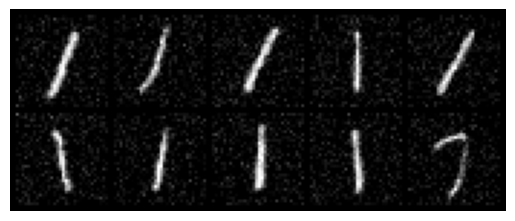

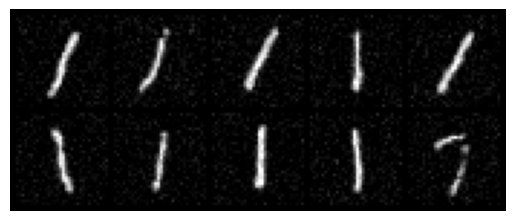

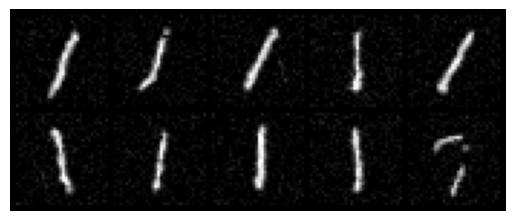

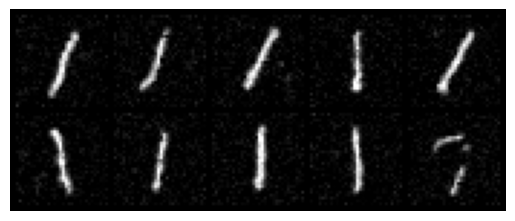

In [57]:
from torchvision.utils import make_grid

grid_samples = make_grid(samples, nrow=5)

grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
#plt.figure(figsize=(6, 6))
plt.imshow(grid_img, cmap='Greys')
plt.axis("off")
plt.show()

for step in range(len(history)):
  grid_samples = make_grid(history[step], nrow=5)

  grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
  #plt.figure(figsize=(6, 6))
  plt.imshow(grid_img, cmap='Greys')
  plt.axis("off")
  plt.show()

# Diffusion: UNet

## Train

In [61]:
def train_ddpm(
    model: object,
    train_loader: object,
    n_epochs: int,
    lr: float,
    beta: torch.Tensor,
    use_cuda: bool = False,
    weights_path: str = ''
) -> dict:

  if use_cuda:
      model.cuda()
  model.train()
  loss_func = nn.MSELoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  alpha_hat = torch.cumprod(1 - beta, 0)
  loss_history = {"loss": []}
  for epoch_i in range(n_epochs):
    train_loss = 0
    for batch_i, x in tqdm(enumerate(train_loader)):
      x = x[0]
      batch_size = x.shape[0]
      if use_cuda:
        x = x.cuda()


      labels = torch.randint(len(beta), (batch_size,))
      alpha_batch = alpha_hat[labels].to(x.device)
      alpha_batch = alpha_batch.reshape(-1, *([1]*(len(x.shape) - 1)))

      standart_noise = torch.randn_like(x)
      x_noisy = torch.sqrt(alpha_batch) * x + standart_noise * torch.sqrt(1 - alpha_batch)


      optimizer.zero_grad()
      pred_noise = model(x_noisy, labels.to(x.device))

      loss = loss_func(pred_noise, standart_noise)

      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    train_loss /= len(train_loader)
    loss_history["loss"].append(train_loss)


    clear_output()
    plt.plot(loss_history["loss"])
    plt.suptitle('%d / %d - train loss: %f' % (epoch_i + 1, n_epochs, train_loss))
    plt.show()

    if epoch_i == 0 or (epoch_i + 1) % 10 == 0:
      torch.save(model.state_dict(), weights_path + '_{}.pth'.format(epoch_i + 1))

  return loss_history

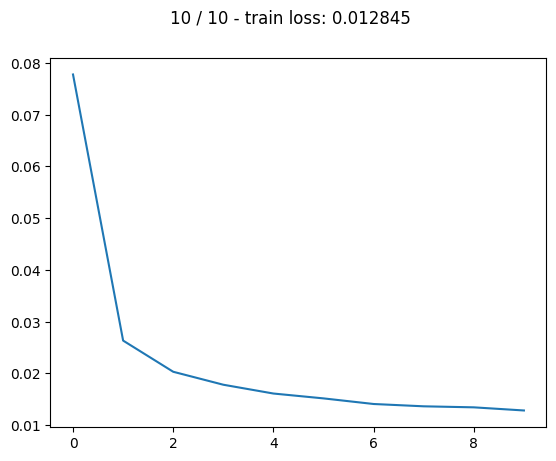

In [62]:
T = 1000
beta = torch.tensor(np.linspace(1e-4, 0.02, T)).float()

unet_model = UNet(image_channels=1)

loss_history = train_ddpm(model=unet_model,
                          train_loader=mnist_dataloader,
                          n_epochs=10,
                          lr=2e-5,
                          beta=beta,
                          use_cuda=USE_CUDA,
                          weights_path='/content/drive/MyDrive/NCSN/diffusion_mnist_unet')

## Sampling

In [63]:
def diffusion_sample(model, n_samples: int,
                      n_steps: int,
                      beta: torch.Tensor,
                      eps: float = 0.00005,
                      save_history: bool = False,
                      save_freq: int = 100) -> torch.Tensor:

  x_k = torch.randn(n_samples, 1, 32, 32).cuda()
  history = []

  alpha_hat = torch.cumprod(1 - beta, 0)
  with torch.no_grad():
    for t in range(n_steps - 1, 0, -1):
      t_batch = torch.ones(n_samples, device=x_k.device, dtype=torch.int) * t
      noise = model(x_k, t_batch)
      sigma_t = np.sqrt(beta[t])
      noise_coef = beta[t] / np.sqrt(1 - alpha_hat[t])
      x_k = (x_k - noise_coef * noise.detach()) / np.sqrt(1 - beta[t]) + sigma_t * torch.randn_like(x_k)

      if save_history and t % save_freq == 0:
        history.append(x_k.cpu())

  if save_history:
    return x_k.cpu(), history

  return x_k.cpu()

In [64]:
unet_model.eval()
T = 1000
samples, history = diffusion_sample(unet_model, n_samples=10, n_steps=T, beta=beta, save_history=True)

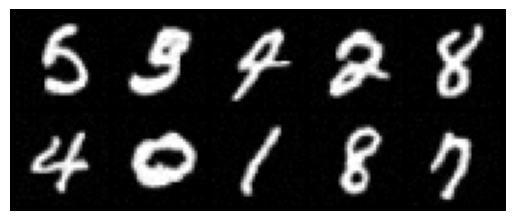

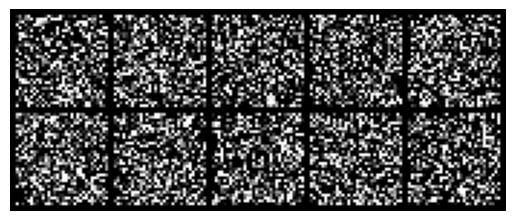

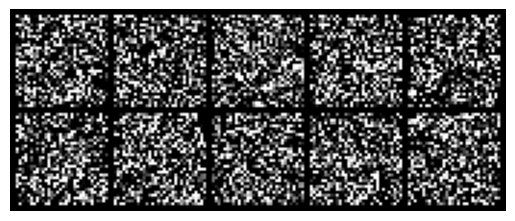

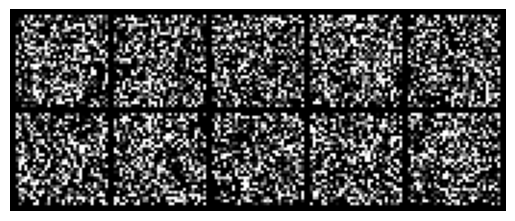

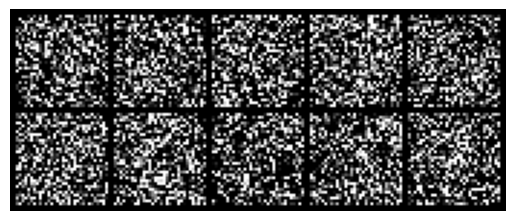

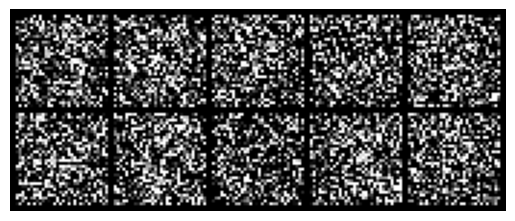

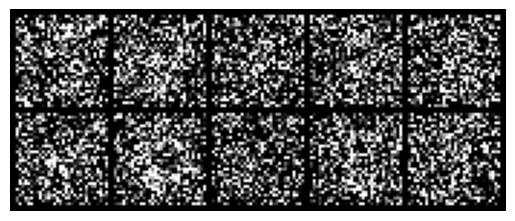

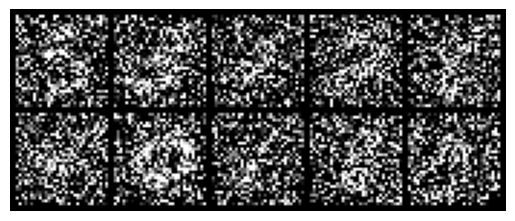

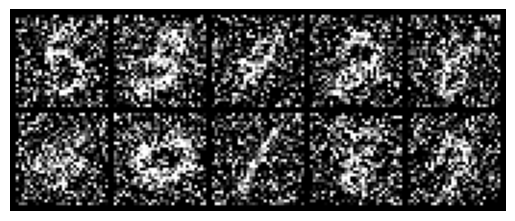

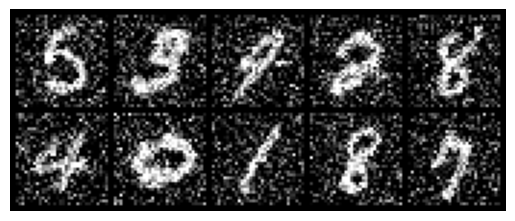

In [65]:
from torchvision.utils import make_grid

grid_samples = make_grid(samples, nrow=5)

grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
#plt.figure(figsize=(6, 6))
plt.imshow(grid_img, cmap='Greys')
plt.axis("off")
plt.show()

for step in range(len(history)):
  grid_samples = make_grid(history[step], nrow=5)

  grid_img = grid_samples.permute(1, 2, 0).clip(0, 1)
  #plt.figure(figsize=(6, 6))
  plt.imshow(grid_img, cmap='Greys')
  plt.axis("off")
  plt.show()